# Tutorial for `triadic_interaction` Package

Last update: 2023-10-31 by jym16

### Introduction

This notebook serves as a tutorial to demonstrate how to make use of the `triadic_interaction` package. 
`triadic_interaction` is a python package developed to simulate node dynamics on networks with triadic interactions. 
Here, we define a triadic interaction as a regulation of dyadic interaction between two nodes by a third node. 
Such triadic interactions are omnipresent in nature: for example, regulations of neuronal signals between two neurons by a glia. 
This python package serves as a tool to simulate a simple node dynamics in the presence of triadic interactions. 

In [1]:
# Prerequisites:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set the seed for random number generator
seed = 123456789
np.random.seed(seed)

### 0.) Import 

In [3]:
from triadic_interaction import *

### 1.) Prepare a network with triadic interactions

For simplicity, we consider the following networks with 3 nodes.


In [4]:
""" Motif (a) """
n_nodes = 3                                        # Number of nodes
n_edges = 1                                        # Number of edges
edge_list = [[2, 3]]                               # Edge list
B = create_node_edge_incidence_matrix(edge_list)   # Incident matrix
TIs = np.zeros((n_edges, n_nodes), dtype=np.int_)  # Triadic interaction 
TIs[0, 0] = 1

### 2.) Define model parameters & initial conditions

In [5]:
w_pos = 2.0                        # Strength of positive TIs
w_neg = 1.0                        # Strength of negative TIs
threshold = 1.0e-3                 # Threshold to turn on/off triadic effects
alpha = 1.0e0                      # Rate of convergence to zero
noise_std = 1.0e-2                 # Noise amplitude
dt = 1.0e-2                        # Time step size
t_max = 1.0e2                      # Maximum time
n_timesteps = int(1 + t_max / dt)  # Number of time steps

In [6]:
x_init = np.zeros(n_nodes) # Initial condition

In [7]:
bin_style = ('percentile', 20)

### 3.) Run a simulation

In [8]:
model = NDwTIs(
    B=B, K=TIs, w_pos=w_pos, w_neg=w_neg, 
    threshold=threshold, alpha=alpha, noise_std=noise_std,
    x_init=x_init, dt=dt, t_max=t_max
)

In [9]:
# Run the model
time_series = model.run()

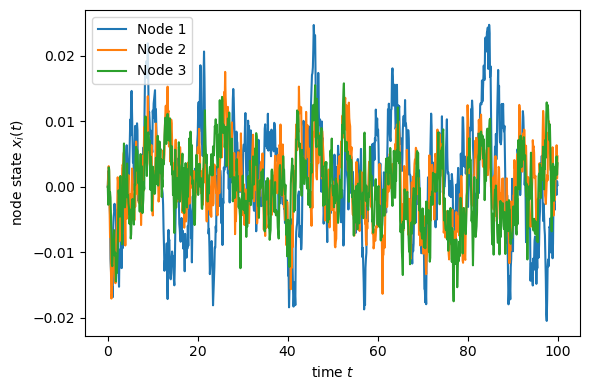

In [10]:
time = np.linspace(0, t_max, n_timesteps)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for i in range(n_nodes):
    ax.plot(time[::10], time_series[i, ::10], "-", label='Node {:d}'.format(i+1))
ax.set_xlabel(r'time $t$')
ax.set_ylabel(r'node state $x_{i}(t)$')
ax.legend()
fig.tight_layout()
plt.show()

### 4.) Run multiple times to take statistics

Takes approximately 1 minute with 100 samples.
(However, 100 samples are not sufficiently large.)

Takes approximately 10 minute with 1000 samples.

In [11]:
n_samples = 1000 # 100
print_frequency = n_samples // 20

In [12]:
data = np.zeros((n_nodes, n_timesteps, n_samples))

for i in range(n_samples):
    if (i+1) % print_frequency == 0:
        print('Iteration {:d} / {:d}'.format(i+1, n_samples))
    model = NDwTIs(
        B=B, K=TIs, w_pos=w_pos, w_neg=w_neg, 
        threshold=threshold, alpha=alpha, noise_std=noise_std,
        x_init=x_init, dt=dt, t_max=t_max
    )
    data[:, :, i] = model.run()

Iteration 50 / 1000
Iteration 100 / 1000
Iteration 150 / 1000
Iteration 200 / 1000
Iteration 250 / 1000
Iteration 300 / 1000
Iteration 350 / 1000
Iteration 400 / 1000
Iteration 450 / 1000
Iteration 500 / 1000
Iteration 550 / 1000
Iteration 600 / 1000
Iteration 650 / 1000
Iteration 700 / 1000
Iteration 750 / 1000
Iteration 800 / 1000
Iteration 850 / 1000
Iteration 900 / 1000
Iteration 950 / 1000
Iteration 1000 / 1000


### 5.) Visualize the stationary node state distribution

In [13]:
# Trim the time series to remove the initial transient dynamics
data = data[:, n_timesteps//2:, :]

In [14]:
pdf_x, x_bins = estimate_pdf(time_series[0], bins=bin_style)
pdf_y, y_bins = estimate_pdf(time_series[1], bins=bin_style)
pdf_z, z_bins = estimate_pdf(time_series[2], bins=bin_style)

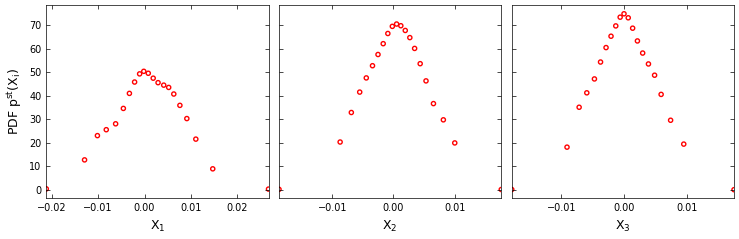

In [15]:
fig = plot_pdf(
    probs=[pdf_x, pdf_y, pdf_z], 
    bins=[x_bins, y_bins, z_bins],
    output_file='stationary_distribution.pdf',
    parallel=True
)

### 6.) Visualize the covariance matrix

In [16]:
# Compute the covariance
cov = covariance(data)

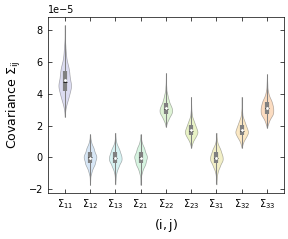

In [17]:
fig = plot_covariance(
    cov, 
    output_file='covariance.pdf'
)

### 7.) Visualize the conditional correlation coefficient

In [18]:
# Compute the conditional correlation
cond_corr_123, x_grid_123, stderr_123 = conditional_correlation(
    X=data[0].flatten(),
    Y=data[1].flatten(),
    Z=data[2].flatten(),
    bins=bin_style
)

cond_corr_132, x_grid_132, stderr_132 = conditional_correlation(
    X=data[0].flatten(),
    Y=data[2].flatten(),
    Z=data[1].flatten(),
    bins=bin_style
)

cond_corr_231, x_grid_231, stderr_231 = conditional_correlation(
    X=data[1].flatten(),
    Y=data[2].flatten(),
    Z=data[0].flatten(),
    bins=bin_style
)

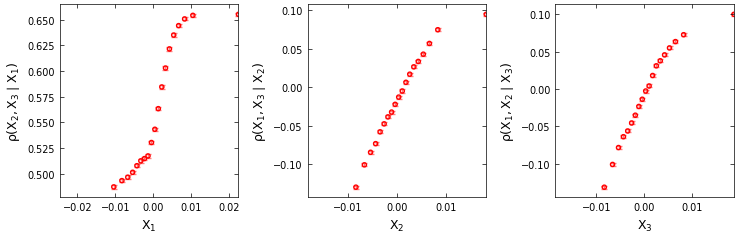

In [19]:
# Plot the conditional correlation with standard errors
fig = plot_conditional_correlation(
    Xgrids=[x_grid_231, x_grid_132, x_grid_123], 
    cond_corr=[cond_corr_231, cond_corr_132, cond_corr_123],
    order=[(2,3,1), (1,3,2), (1,2,3)],
    output_file='conditional_correlation.pdf', 
    std=[stderr_231, stderr_132, stderr_123]
)

### 8.) Visualize the conditional mutual information

In [20]:
cmi_231, _, x_grid_231 = conditional_mutual_information(
    X=data[1].flatten(),
    Y=data[2].flatten(),
    Z=data[0].flatten(), 
    bins=bin_style,
    pmf_method='kde',
    method='kl-div'
)
cmi_132, _, x_grid_132 = conditional_mutual_information(
    X=data[0].flatten(),
    Y=data[2].flatten(),
    Z=data[1].flatten(), 
    bins=bin_style,
    pmf_method='kde',
    method='kl-div'
)
cmi_123, _, x_grid_123 = conditional_mutual_information(
    X=data[0].flatten(),
    Y=data[1].flatten(),
    Z=data[2].flatten(), 
    bins=bin_style,
    pmf_method='kde',
    method='kl-div'
)

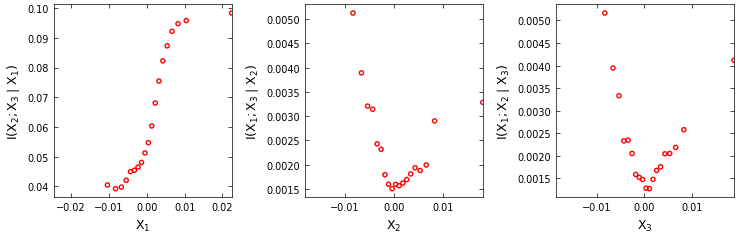

In [21]:
fig = plot_conditional_mutual_information(
    Xgrids=[x_grid_231, x_grid_132, x_grid_123], 
    cmi=[cmi_231, cmi_132, cmi_123],
    order=[(2,3,1), (1,3,2), (1,2,3)],
    output_file='conditional_mutual_information.pdf'
)